In [2]:
import os

import pandas as pd
import numpy as np

from math import sqrt

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy import stats

import xgboost as xgb

In [76]:
dirpath = 'z3'
df = pd.concat([pd.read_csv(os.path.join(dirpath, fname))
                for fname in os.listdir(dirpath)], ignore_index=True)

df['czas'] = df['czas'].str[:19]
df['czas'] = pd.to_datetime(df['czas'], format='%Y-%m-%d %H:%M:%S')

col_df = pd.read_excel('opis_zmiennych.xlsx')
col_df['opis'] = col_df['opis'] + ' ' + col_df['Jednostka']
col_df.drop(columns=['Jednostka'], inplace=True)

names_dict = col_df.set_index('Tagname').to_dict()['opis']
names_dict =  {k.lower(): v for k, v in names_dict.items()}

df.rename(columns=names_dict, inplace=True)

temp = pd.read_csv('temp_zuz.csv', delimiter=';')
temp.rename(columns={'Czas': 'czas'}, inplace=True)
temp['czas'] = pd.to_datetime(temp['czas'])

merged = pd.merge(df, temp, how='left', on='czas')

In [83]:
df = merged.copy()
df.set_index(['czas'], inplace=True)
df = df[~df.index.duplicated()]
df = df.asfreq('T')
df.index

DatetimeIndex(['2020-10-01 00:00:00', '2020-10-01 00:01:00',
               '2020-10-01 00:02:00', '2020-10-01 00:03:00',
               '2020-10-01 00:04:00', '2020-10-01 00:05:00',
               '2020-10-01 00:06:00', '2020-10-01 00:07:00',
               '2020-10-01 00:08:00', '2020-10-01 00:09:00',
               ...
               '2022-01-31 23:50:00', '2022-01-31 23:51:00',
               '2022-01-31 23:52:00', '2022-01-31 23:53:00',
               '2022-01-31 23:54:00', '2022-01-31 23:55:00',
               '2022-01-31 23:56:00', '2022-01-31 23:57:00',
               '2022-01-31 23:58:00', '2022-01-31 23:59:00'],
              dtype='datetime64[ns]', name='czas', length=702720, freq='T')

In [84]:
def last_h(df, n_hours):
    temp = df['temp_zuz'].copy()
    for n in range(1, n_hours+1):
        label = 'temp_last' + '_' + str(n)
        df[label] = temp.fillna(method='ffill').shift(periods=1+60*(n-1))

In [85]:
last_h(df, 4)

cols = list(df.columns)
cols.remove('temp_zuz')

df = df.dropna(subset=cols)

In [47]:
# def remove_when_off(df, min_off, margin):
#     what = np.full(df.shape[0], True)
#     temp_series = df['temp_zuz']
#     max_idx = df.shape[0]-1
#     for index, (date, temp) in enumerate(temp_series.iteritems()):
#         if temp <= min_off:
#             from_idx, to_idx = index-margin, index+margin
#             if from_idx < 0 : from_idx = 0
#             if to_idx > max_idx : to_idx = max_idx
#             what[from_idx:to_idx] = False
#     return df[what], df[~what]

In [48]:
# df, _ = remove_when_off(df, 1270, 15)

In [9]:
# df['minute'] = df.index.minute.values

In [10]:
# corr = np.abs(df.drop(columns=['temp_zuz']).corrwith(df['temp_zuz'])).sort_values(ascending=False)
# corr.plot(kind='bar', figsize=(22, 10))

In [11]:
# weather_df = pd.read_csv('wheather.csv')

In [12]:
# weather_df['czas'] = pd.to_datetime(weather_df['index'])
# weather_df.drop(columns=['index'], inplace=True)
# weather_df.set_index(['czas'], inplace=True)

# weather_df = weather_df[~weather_df.index.duplicated()]
# weather_df = weather_df.asfreq('T')
# # weather_df.index

In [13]:
# weather_df.fillna(method='ffill', inplace=True)
# weather_df.rename(columns={'temperature': 'weather_temp'}, inplace=True)

In [86]:
col_names = ['REG NADAWY KONCENTRATU LIW1 Mg/h', 'REG NADAWY KONCENTRATU LIW2 Mg/h',
       'REG KONCENTRAT PRAZONY LIW3 Mg/h', 'REG PYL ZWROT LIW4 Mg/h',
       'WODA CHŁODZĄCA DO KOLEKTOR KZ7 m3/h',
       'WODA CHŁODZĄCA DO KOLEKTOR KZ8 m3/h',
       'WODA CHŁODZĄCA DO KOLEKTOR KZ9 m3/h',
       'WODA CHŁODZĄCA DO KOLEKTOR KZ10 m3/h',
       'WODA CHŁODZĄCA DO KOLEKTOR KZ11 m3/h',
       'WODA CHŁODZĄCA DO KOLEKTOR KZ12 m3/h',
       'WODA CHŁODZĄCA DO KOLEKTOR KZ13 m3/h',
       'WODA CHŁODZĄCA DO KOLEKTOR KZ15 m3/h',
       'SUMARYCZNA MOC CIEPLNA ODEBRANA - CAŁKOWITA MW',
       'WODA POWROTNA KOLEKTORA KZ7 °C', 'WODA POWROTNA KOLEKTORA KZ8 °C',
       'WODA POWROTNA KOLEKTORA KZ9 °C']

new_df = df.copy()

new_df = pd.concat([new_df, new_df[col_names].rename(columns=lambda col_name: f'{col_name}_avg_00-15').rolling(window=15).mean()], axis=1)
new_df = pd.concat([new_df, new_df[col_names].shift(periods=15, freq='min').rename(columns=lambda col_name: f'{col_name}_avg_15-30').rolling(window=15).mean()], axis=1)
new_df = pd.concat([new_df, new_df[col_names].shift(periods=30, freq='min').rename(columns=lambda col_name: f'{col_name}_avg_30-45').rolling(window=15).mean()], axis=1)
new_df = pd.concat([new_df, new_df[col_names].shift(periods=45, freq='min').rename(columns=lambda col_name: f'{col_name}_avg_45-60').rolling(window=15).mean()], axis=1)
    

In [16]:
# df = new_df.dropna(subset=cols)

<AxesSubplot:>

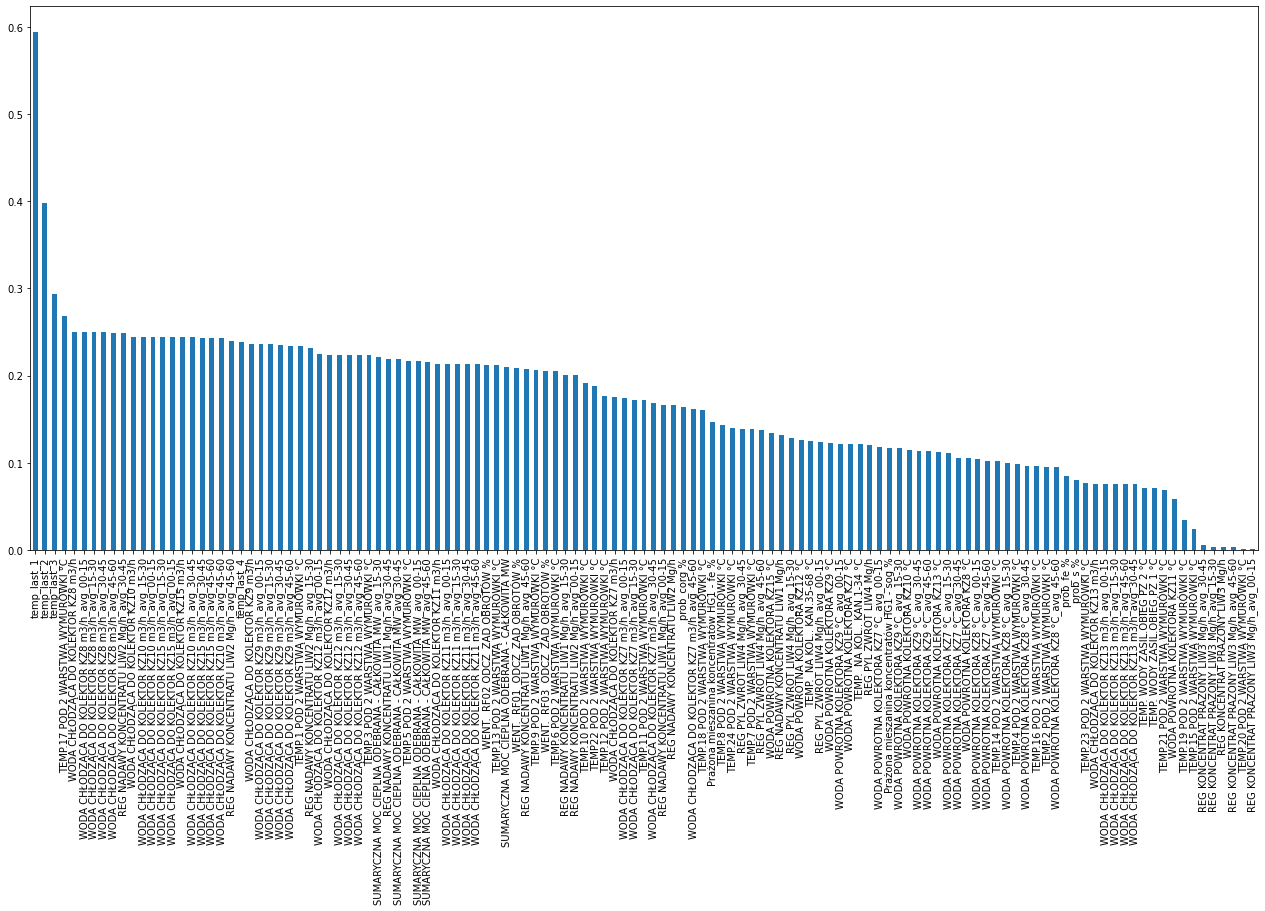

In [89]:
corr = np.abs(new_df.drop(columns=['temp_zuz']).corrwith(new_df['temp_zuz'])).sort_values(ascending=False)
corr.plot(kind='bar', figsize=(22, 10))

In [91]:
threshold = 0.165

correlated_cols = new_df.columns[new_df.corr()['temp_zuz'].abs() > threshold].tolist()
corr_df = new_df[correlated_cols].copy()

In [92]:
corr_df['temp_zuz'] = corr_df['temp_zuz'].interpolate()
df = corr_df.dropna()

In [93]:
df = df[(np.abs(stats.zscore(df)) < 3).all(axis=1)]

In [95]:
df['minute'] = df.index.minute.values
df['minute'] = np.where(df['minute'] == 0, 60, df['minute'])

In [108]:
small_df = df.iloc[:10000]
small_df.shape

(10000, 68)

In [126]:
model = xgb.XGBRegressor(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=5,
    )
cv = TimeSeriesSplit(5)

pipe = Pipeline(steps=[
    ('scalar', StandardScaler()),
    ('xgb', model)])

# pipe.fit(df.drop(['temp_zuz']), df['temp_zuz'])

scores = cross_val_score(pipe,
                         df.drop(columns=['temp_zuz']),
                         df['temp_zuz'],
                         scoring='neg_mean_squared_error',
                         cv=cv)

scores = np.sqrt(np.absolute(scores))
print('Mean RMSE: %.3f (%.3f)' % (scores.mean(), scores.std()))

Mean RMSE: 3.416 (0.119)


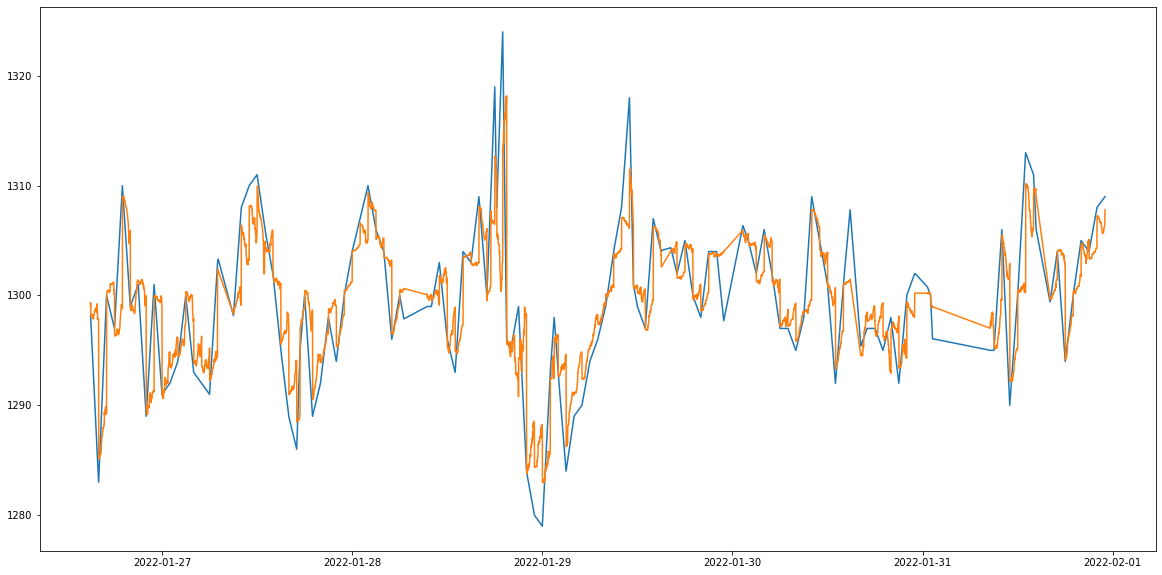

In [127]:
X_train, X_test, y_train, y_test = train_test_split(
        df.drop(columns=['temp_zuz']),
        df['temp_zuz'],
        test_size=0.01,
        shuffle=False
        )


pipe.fit(X_train, y_train)
y_hat = pipe.predict(X_test)

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))

plt.plot(X_test.index, y_test)
plt.plot(X_test.index, y_hat)


In [128]:
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_hat))}')

RMSE: 3.734680520389468


In [102]:
y_hat = model.predict(X_test[X_test.index.minute == 0])
print(f'RMSE: {np.sqrt(mean_squared_error(y_test[y_test.index.minute == 0], y_hat))}')

RMSE: 5.764802359974859
